In [14]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
import json
import os
import multiprocessing
cpu_count = multiprocessing.cpu_count()

import xgboost as xgb

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
from pprint import pprint
import sys
from sklearn.utils import resample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:


# path = "F:\\twitter_data\\givenchy\\pickle\\"
# event = 'givenchy'
# interval = 30
# current_time = 360
# start_hour = 6


def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y

    
# users = load_pickle_file(path+"users.dat")
# users.reset_index(drop =True , inplace =True)
# # print(users)
# print(users.columns)
# print(users['source_candidates'])


# print(unique_users)
def id_exists(unique_users, uid):
    if uid in unique_users:
        return True
    return False

def filter_id_list(unique_users, value):
        return list(filter(lambda uid: id_exists(unique_users,uid), value))
    

def network_simulation_init(users, start_hour):
    current_time = start_hour*60 
    network_simulation = pd.DataFrame(columns= ['id','time_lapsed','favourites_count','followers_count','friends_count',
                                'listed_count','statuses_count','source_candidates','source_index','seed_index','generation',
                                 'time_since_seed','user_created_days','normalized_statuses_count','normalized_followers_count',
                                 'normalized_favourites_count','normalized_listed_count','normalized_friends_count'])

    network_simulation['id']=users['id']
    network_simulation['favourites_count']=users['favourites_count']
    network_simulation['followers_count']=users['followers_count']
    network_simulation['friends_count']=users['friends_count']
    network_simulation['listed_count']=users['listed_count']
    network_simulation['statuses_count']=users['statuses_count']
    network_simulation['user_created_days']=users['user_created_days']
    network_simulation['normalized_statuses_count']=users['normalized_statuses_count']
    network_simulation['normalized_followers_count']=users['normalized_followers_count']
    network_simulation['normalized_favourites_count']=users['normalized_favourites_count']
    network_simulation['normalized_listed_count']=users['normalized_listed_count']
    network_simulation['normalized_friends_count']=users['normalized_friends_count']
    network_simulation['time_lapsed'] = users['time_lapsed'].apply(lambda x: x if x <= current_time else None)
    network_simulation['source_index'] = users.apply(lambda x: x['source_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['seed_index'] = users.apply(lambda x: x['seed_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['generation'] = users.apply(lambda x: x['generation'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['time_since_seed'] = users.apply(lambda x: x['time_since_seed'] if x['time_lapsed'] <= current_time else None,axis=1)

# print("network_simulation")
# print(network_simulation)
    return network_simulation


def network_simulation_merge_friends_list(network_simulation, path_of_friends_list):

    friends = load_pickle_file(path_of_friends_list)
    friends_list = pd.DataFrame(columns=['id'], data=friends.keys())
    friends_list["friends_list"] = ''
    for i in range (0, len(friends)):
        friends_list["friends_list"][i]= friends.get(friends_list["id"][i])
    friends_list.reset_index(drop =True , inplace =True)
    network_simulation = pd.merge(network_simulation,friends_list, on='id', left_index=True,how='left')
    return

def network_simulation_merge_followers_list(network_simulation, path_of_followers_list):
    followers = load_pickle_file(path_of_followers_list)
    followers_list = pd.DataFrame(columns=['id'], data=followers.keys())
    followers_list["followers_list"] = ''
    for i in range (0, len(followers)):
        followers_list["followers_list"][i]= followers.get(followers_list["id"][i])
    # print(friends_list.get(942362499923566592 ))
    followers_list.reset_index(drop =True , inplace =True)
    # print(followers_list)


    network_simulation = pd.merge(network_simulation,followers_list,on='id', left_index=True,how='left')
    return
#     print(network_simulation)



def process_data(users, network_simulation, start_index, end_index,start_hour):
    
    current_time = start_hour*60   
    in_degree = list(users.friends_count)
    out_degree = list(users.followers_count)
    degree = (users.friends_count+users.followers_count).tolist()
    
    features = {
        #Columns which are added for simulation, but they are not used as features for model prediction
        'user_id':[],
        'infected_status':[],
        'infection_time':[],
        'followers_list':[],
        
        #Columns used as features for model prediction   33
        'UsM_deltaDays': [],
        'UsM_statusesCount': [],
        'UsM_followersCount': [],
        'UsM_favouritesCount': [],
        'UsM_friendsCount': [],
        'UsM_listedCount': [],
        'UsM_normalizedUserStatusesCount': [],
        'UsM_normalizedUserFollowersCount': [],
        'UsM_normalizedUserFavouritesCount': [],
        'UsM_normalizedUserListedCount': [],
        'UsM_normalizedUserFriendsCount': [],          
        'UsM_deltaDays0': [],
        'UsM_statusesCount0': [],
        'UsM_followersCount0': [],
        'UsM_favouritesCount0': [],
        'UsM_friendsCount0': [],
        'UsM_listedCount0': [],
        'UsM_normalizedUserStatusesCount0': [],
        'UsM_normalizedUserFollowersCount0': [],
        'UsM_normalizedUserFavouritesCount0': [],
        'UsM_normalizedUserListedCount0': [],
        'UsM_normalizedUserFriendsCount0': [],
        'UsM_deltaDays-1': [],
        'UsM_statusesCount-1': [],
        'UsM_followersCount-1': [],
        'UsM_favouritesCount-1': [],
        'UsM_friendsCount-1': [],
        'UsM_listedCount-1': [],
        'UsM_normalizedUserStatusesCount-1': [],
        'UsM_normalizedUserFollowersCount-1': [],
        'UsM_normalizedUserFavouritesCount-1': [],
        'UsM_normalizedUserListedCount-1': [],
        'UsM_normalizedUserFriendsCount-1': [],
        # TwM: Tweet metadata   5
        'TwM_t0': [],
        'TwM_tSeed0': [],
        'TwM_t-1': [],
        'TwM_tSeed-1': [],
        'TwM_tCurrent': [],
        # Nw: Network0    15
        'Nw_degree': [],
        'Nw_inDegree': [],
        'Nw_outDegree': [],
        'Nw_degree0': [],
        'Nw_inDegree0': [],
        'Nw_outDegree0': [],
        'Nw_degree-1': [],
        'Nw_inDegree-1': [],
        'Nw_outDegree-1': [],
        'Nw_degreeSeed0': [],
        'Nw_inDegreeSeed0': [],
        'Nw_outDegreeSeed0': [],
        'Nw_degreeSeed-1': [],
        'Nw_inDegreeSeed-1': [],
        'Nw_outDegreeSeed-1': [],
        # SNw: Spreading Network   20
        'SNw_nFriendsInfected': [],
        'SNw_friendsInfectedRatio': [],
        'SNw_generation0': [],
        'SNw_generation-1': [],
        'SNw_timeSinceSeed0': [],
        'SNw_timeSinceSeed-1': [],
        'SNw_totalNodesInfected': [],
        'SNw_nodeInfectedCentrality': [],
        'SNw_totalInDegree': [],
        'SNw_totalOutDegree': [],
        'SNw_inDegreeCentrality': [],
        'SNw_inDegreeCentrality0': [],
        'SNw_inDegreeCentrality-1': [],
        'SNw_outDegreeCentrality': [],
        'SNw_outDegreeCentrality0': [],
        'SNw_outDegreeCentrality-1': [],
        'SNw_inDegreeCentralitySeed0':[],
        'SNw_outDegreeCentralitySeed0':[],
        'SNw_inDegreeCentralitySeed-1':[],
        'SNw_outDegreeCentralitySeed-1':[],
        # Stat: Statistical  15
        'Stat_average_kOut': [],
        'Stat_average_t': [],
        'Stat_average_deltaDays': [],
        'Stat_average_statusesCount': [],
        'Stat_average_followersCount': [],
        'Stat_average_favouritesCount': [],
        'Stat_average_friendsCount': [],
        'Stat_average_listedCount': [],
        'Stat_average_normalizedUserStatusesCount': [],
        'Stat_average_normalizedUserFollowersCount': [],
        'Stat_average_normalizedUserFavouritesCount': [],
        'Stat_average_normalizedUserListedCount': [],
        'Stat_average_normalizedUserFriendsCount': [],                
        'Stat_max_kOut': [],
        'Stat_min_kOut': []
        
    }

    with tqdm(total=len(list(users[start_index: end_index].iterrows()))) as pbar: 
        for index, user_row in users[start_index: end_index].iterrows():
            source_candidates = sorted(user_row['source_candidates'])
            features['user_id'].append(user_row['id'])
            features['infected_status'].append(False)
            features['infection_time'].append(None)
            #print(f"user_row['followers_list']:{user_row['followers_list']}")
            features['followers_list'].append(user_row['followers_json'])
            #print("b")
            features['UsM_deltaDays'].append(user_row['user_created_days'])
            features['UsM_statusesCount'].append(user_row['statuses_count'])
            features['UsM_followersCount'].append(user_row['followers_count'])
            features['UsM_favouritesCount'].append(user_row['favourites_count'])
            features['UsM_friendsCount'].append(user_row['friends_count'])
            features['UsM_listedCount'].append(user_row['listed_count'])
            features['UsM_normalizedUserStatusesCount'].append(user_row['normalized_statuses_count'])
            features['UsM_normalizedUserFollowersCount'].append(user_row['normalized_followers_count'])
            features['UsM_normalizedUserFavouritesCount'].append(user_row['normalized_favourites_count'])
            features['UsM_normalizedUserListedCount'].append(user_row['normalized_listed_count'])
            features['UsM_normalizedUserFriendsCount'].append(user_row['normalized_friends_count'])
            if isinstance(source_candidates, list):
                sources = network_simulation.loc[source_candidates]
                sources_dataframe = sources[sources['time_lapsed'] <= current_time]
#                 if user_row['time_lapsed'] > current_time:
#                     sources_dataframe = sources[sources['time_lapsed'] <= current_time]
#                 else:
#                      sources_dataframe = sources[sources['time_lapsed'] <= user_row['time_lapsed']]
                sources = sources_dataframe.index.tolist()
            else:
                sources = []
            #sources = [x for x in source_candidates if users.loc[x,'time_lapsed'] <= current_time]
            #print(f'sources:{sources}')
            if len(sources) > 0:

                # Assign the values here to save computation
                first_source_index = source_candidates[0]
                first_source_row = users.loc[first_source_index]
                first_source_seed_row = users.loc[first_source_row['seed_index']]

                inDegreeList = sources_dataframe.friends_count.tolist()
                outDegreeList = sources_dataframe.followers_count.tolist()
                degreeList = [x + y for x, y in zip(inDegreeList, outDegreeList)]
                
                s_ind = sources_dataframe.friends_count
                s_outd = sources_dataframe.followers_count
                outDegreeList = s_outd.tolist()
                inDegreeList = s_ind.tolist()
                degreeList = (s_ind + s_outd).tolist()

                #degreeList = list(users.loc[i, 'followers_count'] + users.loc[i, 'friends_count']  for i in sources)
                current_time_series = pd.Series([current_time] * len(sources))
                time_lapsed_series = sources_dataframe.time_lapsed
                timeList = (current_time_series - time_lapsed_series).tolist()


                last_source_index = sources[-1]
                last_source_row = network_simulation.loc[last_source_index]
                last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]

                usr_index = index

                if user_row['time_lapsed'] <= current_time:

                    features['infected_status'][-1] = True
                    features['infection_time'][-1] = user_row['time_lapsed']

                    network_simulation.loc[usr_index,'time_lapsed'] = user_row['time_lapsed']

                    network_simulation.loc[usr_index,'source_index'] = user_row['source_index']
                    network_simulation.loc[usr_index,'seed_index'] = user_row['seed_index']
                    network_simulation.loc[usr_index, 'generation'] = user_row['generation']
                    network_simulation.loc[usr_index, 'time_since_seed'] = user_row['time_since_seed']


                network_simulation.at[usr_index,'source_candidates'] = sources

                # UsM: User metadata

                features['UsM_deltaDays0'].append(first_source_row.user_created_days)
                features['UsM_statusesCount0'].append(first_source_row.statuses_count)
                features['UsM_followersCount0'].append(first_source_row.followers_count)
                features['UsM_favouritesCount0'].append(first_source_row.favourites_count)
                features['UsM_friendsCount0'].append(first_source_row.friends_count)
                features['UsM_listedCount0'].append(first_source_row.listed_count)
                features['UsM_normalizedUserStatusesCount0'].append(first_source_row.normalized_statuses_count)
                features['UsM_normalizedUserFollowersCount0'].append(first_source_row.normalized_followers_count)
                features['UsM_normalizedUserFavouritesCount0'].append(first_source_row.normalized_favourites_count)
                features['UsM_normalizedUserListedCount0'].append(first_source_row.normalized_listed_count)
                features['UsM_normalizedUserFriendsCount0'].append(first_source_row.normalized_friends_count)
                features['UsM_deltaDays-1'].append(last_source_row.user_created_days)
                features['UsM_statusesCount-1'].append(last_source_row.statuses_count)
                features['UsM_followersCount-1'].append(last_source_row.followers_count)
                features['UsM_favouritesCount-1'].append(last_source_row.favourites_count)
                features['UsM_friendsCount-1'].append(last_source_row.friends_count)
                features['UsM_listedCount-1'].append(last_source_row.listed_count)
                features['UsM_normalizedUserStatusesCount-1'].append(last_source_row.normalized_statuses_count)
                features['UsM_normalizedUserFollowersCount-1'].append(last_source_row.normalized_followers_count)
                features['UsM_normalizedUserFavouritesCount-1'].append(last_source_row.normalized_favourites_count)
                features['UsM_normalizedUserListedCount-1'].append(last_source_row.normalized_listed_count)
                features['UsM_normalizedUserFriendsCount-1'].append(last_source_row.normalized_friends_count)
                # TwM: Tweet metadata
                features['TwM_t0'].append(round(timeList[0], 1))
                features['TwM_tSeed0'].append(round(current_time - first_source_seed_row['time_lapsed'], 1))
                features['TwM_t-1'].append(round(timeList[-1], 1))
                features['TwM_tSeed-1'].append(round(current_time - last_source_seed_row['time_lapsed'], 1))
                features['TwM_tCurrent'].append(current_time)
                # Nw: Network
                features['Nw_degree'].append(degree[index])
                features['Nw_inDegree'].append(in_degree[index])
                features['Nw_outDegree'].append(out_degree[index])
                features['Nw_degree0'].append(degree[first_source_index])
                features['Nw_inDegree0'].append(in_degree[first_source_index])
                features['Nw_outDegree0'].append(out_degree[first_source_index])
                features['Nw_degree-1'].append(degree[last_source_index])
                features['Nw_inDegree-1'].append(in_degree[last_source_index])
                features['Nw_outDegree-1'].append(out_degree[last_source_index])
                features['Nw_degreeSeed0'].append(degree[int(first_source_row['seed_index'])])
                features['Nw_inDegreeSeed0'].append(in_degree[int(first_source_row['seed_index'])])
                features['Nw_outDegreeSeed0'].append(out_degree[int(first_source_row['seed_index'])])
                features['Nw_degreeSeed-1'].append(degree[int(last_source_row['seed_index'])])
                features['Nw_inDegreeSeed-1'].append(in_degree[int(last_source_row['seed_index'])])
                features['Nw_outDegreeSeed-1'].append(out_degree[int(last_source_row['seed_index'])])
                # SNw: Spreading Network
                features['SNw_nFriendsInfected'].append(len(sources))
                features['SNw_friendsInfectedRatio'].append(safe_division(len(sources), user_row['friends_count']))
                features['SNw_generation0'].append(first_source_row['generation'])
                features['SNw_generation-1'].append(last_source_row['generation'])
                features['SNw_timeSinceSeed0'].append(first_source_row['time_since_seed'])
                features['SNw_timeSinceSeed-1'].append(last_source_row['time_since_seed'])

                infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
                total_nodes_infected = infected_dataframe.shape[0]
                total_in_degree = sum(infected_dataframe.friends_count)
                total_out_degree = sum(infected_dataframe.followers_count)

                features['SNw_totalNodesInfected'].append(total_nodes_infected)
                features['SNw_nodeInfectedCentrality'].append(len(sources)/total_nodes_infected)
                features['SNw_totalInDegree'].append(total_in_degree)
                features['SNw_totalOutDegree'].append(total_out_degree)
                features['SNw_inDegreeCentrality'].append(in_degree[index]/total_in_degree)
                features['SNw_inDegreeCentrality0'].append(in_degree[first_source_index]/total_in_degree)
                features['SNw_inDegreeCentrality-1'].append(in_degree[last_source_index]/total_in_degree)
                features['SNw_outDegreeCentrality'].append(out_degree[index]/total_out_degree)
                features['SNw_outDegreeCentrality0'].append(out_degree[first_source_index]/total_out_degree)
                features['SNw_outDegreeCentrality-1'].append(out_degree[last_source_index]/total_out_degree)
                features['SNw_inDegreeCentralitySeed0'].append(in_degree[int(first_source_row['seed_index'])]/total_in_degree)
                features['SNw_outDegreeCentralitySeed0'].append(out_degree[int(first_source_row['seed_index'])]/total_out_degree)
                features['SNw_inDegreeCentralitySeed-1'].append(in_degree[int(last_source_row['seed_index'])]/total_in_degree)
                features['SNw_outDegreeCentralitySeed-1'].append(out_degree[int(last_source_row['seed_index'])]/total_out_degree)
                # Stat: Statistical
                features['Stat_average_kOut'].append(round(mean(degreeList), 1))
                features['Stat_average_t'].append(round(mean(timeList), 1))
                features['Stat_average_deltaDays'].append(sources_dataframe.user_created_days.mean())
                features['Stat_average_statusesCount'].append(sources_dataframe.statuses_count.mean())
                features['Stat_average_followersCount'].append(sources_dataframe.followers_count.mean())
                features['Stat_average_favouritesCount'].append(sources_dataframe.favourites_count.mean())
                features['Stat_average_friendsCount'].append(sources_dataframe.friends_count.mean())
                features['Stat_average_listedCount'].append(sources_dataframe.listed_count.mean())
                features['Stat_average_normalizedUserStatusesCount'].append(sources_dataframe.normalized_statuses_count.mean())
                features['Stat_average_normalizedUserFollowersCount'].append(sources_dataframe.normalized_followers_count.mean())
                features['Stat_average_normalizedUserFavouritesCount'].append(sources_dataframe.normalized_favourites_count.mean())
                features['Stat_average_normalizedUserListedCount'].append(sources_dataframe.normalized_listed_count.mean())
                features['Stat_average_normalizedUserFriendsCount'].append(sources_dataframe.normalized_friends_count.mean())
                features['Stat_max_kOut'].append(max(degreeList))
                features['Stat_min_kOut'].append(min(degreeList))
            else:
                features['UsM_deltaDays0'].append(None)
                features['UsM_statusesCount0'].append(None)
                features['UsM_followersCount0'].append(None)
                features['UsM_favouritesCount0'].append(None)
                features['UsM_friendsCount0'].append(None)
                features['UsM_listedCount0'].append(None)
                features['UsM_normalizedUserStatusesCount0'].append(None)
                features['UsM_normalizedUserFollowersCount0'].append(None)
                features['UsM_normalizedUserFavouritesCount0'].append(None)
                features['UsM_normalizedUserListedCount0'].append(None)
                features['UsM_normalizedUserFriendsCount0'].append(None)
                features['UsM_deltaDays-1'].append(None)
                features['UsM_statusesCount-1'].append(None)
                features['UsM_followersCount-1'].append(None)
                features['UsM_favouritesCount-1'].append(None)
                features['UsM_friendsCount-1'].append(None)
                features['UsM_listedCount-1'].append(None)
                features['UsM_normalizedUserStatusesCount-1'].append(None)
                features['UsM_normalizedUserFollowersCount-1'].append(None)
                features['UsM_normalizedUserFavouritesCount-1'].append(None)
                features['UsM_normalizedUserListedCount-1'].append(None)
                features['UsM_normalizedUserFriendsCount-1'].append(None)
                # TwM: Tweet metadata
                features['TwM_t0'].append(None)
                features['TwM_tSeed0'].append(None)
                features['TwM_t-1'].append(None)
                features['TwM_tSeed-1'].append(None)
                features['TwM_tCurrent'].append(None)
                # Nw: Network
                features['Nw_degree'].append(None)
                features['Nw_inDegree'].append(None)
                features['Nw_outDegree'].append(None)
                features['Nw_degree0'].append(None)
                features['Nw_inDegree0'].append(None)
                features['Nw_outDegree0'].append(None)
                features['Nw_degree-1'].append(None)
                features['Nw_inDegree-1'].append(None)
                features['Nw_outDegree-1'].append(None)
                features['Nw_degreeSeed0'].append(None)
                features['Nw_inDegreeSeed0'].append(None)
                features['Nw_outDegreeSeed0'].append(None)
                features['Nw_degreeSeed-1'].append(None)
                features['Nw_inDegreeSeed-1'].append(None)
                features['Nw_outDegreeSeed-1'].append(None)
                # SNw: Spreading Network
                features['SNw_nFriendsInfected'].append(0)
                features['SNw_friendsInfectedRatio'].append(None)
                features['SNw_generation0'].append(None)
                features['SNw_generation-1'].append(None)
                features['SNw_timeSinceSeed0'].append(None)
                features['SNw_timeSinceSeed-1'].append(None)
                features['SNw_totalNodesInfected'].append(None)
                features['SNw_nodeInfectedCentrality'].append(None)
                features['SNw_totalInDegree'].append(None)
                features['SNw_totalOutDegree'].append(None)
                features['SNw_inDegreeCentrality'].append(None)
                features['SNw_inDegreeCentrality0'].append(None)
                features['SNw_inDegreeCentrality-1'].append(None)
                features['SNw_outDegreeCentrality'].append(None)
                features['SNw_outDegreeCentrality0'].append(None)
                features['SNw_outDegreeCentrality-1'].append(None)
                features['SNw_inDegreeCentralitySeed0'].append(None)
                features['SNw_outDegreeCentralitySeed0'].append(None)
                features['SNw_inDegreeCentralitySeed-1'].append(None)
                features['SNw_outDegreeCentralitySeed-1'].append(None)
                # Stat: Statistical
                features['Stat_average_kOut'].append(None)
                features['Stat_average_t'].append(None)
                features['Stat_average_deltaDays'].append(None)
                features['Stat_average_statusesCount'].append(None)
                features['Stat_average_followersCount'].append(None)
                features['Stat_average_favouritesCount'].append(None)
                features['Stat_average_friendsCount'].append(None)
                features['Stat_average_listedCount'].append(None)
                features['Stat_average_normalizedUserStatusesCount'].append(None)
                features['Stat_average_normalizedUserFollowersCount'].append(None)
                features['Stat_average_normalizedUserFavouritesCount'].append(None)
                features['Stat_average_normalizedUserListedCount'].append(None)
                features['Stat_average_normalizedUserFriendsCount'].append(None)
                features['Stat_max_kOut'].append(None)
                features['Stat_min_kOut'].append(None)

            pbar.update(1)
    processed_dataframe = pd.DataFrame(features)
    return processed_dataframe

def data_preparation_process(path_of_user_data, path_of_follower_list, path_of_friend_list, feature_file_path, network_file_path, start_hour=7):
    
    users = load_pickle_file(path_of_user_data)
    users.reset_index(drop =True , inplace =True)
    unique_users = set(users.index)
    print(users['source_candidates'])
    users["source_candidates"] = users["source_candidates"].map(lambda x: filter_id_list(unique_users, x))
    print(users['source_candidates'])
    network_simulation = network_simulation_init(users, start_hour)
    network_simulation_merge_friends_list(network_simulation, path_of_friend_list)
    network_simulation_merge_followers_list(network_simulation, path_of_follower_list)
    start_index = 0
    end_index = 5973
    features = process_data(users, network_simulation, start_index, end_index,start_hour)
    print(network_simulation)
    print(network_simulation['source_candidates'])
    print(network_simulation.at[1000,'source_candidates'])
    save_pickle_file(feature_file_path,features)
    save_pickle_file(network_file_path,network_simulation)



In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def prepare_training_data(initial_features):
    df = initial_features
    
    df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
    df = df.reset_index(drop=True)
    
    df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y

def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

def train(df, X, y, model, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = model.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = model.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = model.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = model.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        #auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst

def data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'up', start_hour=6, model=xgb, param=None):
    initial_features = load_pickle_file(initial_features_path)
    users = load_pickle_file(user_data_path)
    users.reset_index(drop =True , inplace =True)

    df, X, y = prepare_training_data(initial_features)

    feature_columns = X.columns
    print('There are {} Features'.format(len(feature_columns)))
    #xgboost
    if param == None:
        param = {
            'max_depth':3,
            # Step size shrinkage used in update to prevents overfitting. 
            # After each boosting step, we can directly get the weights of new features, 
            # and eta shrinks the feature weights to make the boosting process more conservative.
            'eta': 0.1,
            # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
            # The larger gamma is, the more conservative the algorithm will be.
            'gamma':10,
            # Minimum sum of instance weight (hessian) needed in a child. 
            # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
            # then the building process will give up further partitioning.
            # The larger min_child_weight is, the more conservative the algorithm will be.
            'min_child_weight':10,
            'silent': 1, # 0 means printing running messages, 1 means silent mode
            'objective': 'binary:logistic',
            'subsample': 0.9
        }
    param['nthread'] = cpu_count
    param['eval_metric'] = ['auc']
    num_boost_round = 1000
    rebalance_method = 'up'

    xgb_model = train(df, X, y, model, param, 2, num_boost_round, rebalance_method)
    
    with open(model_save_path, 'wb') as file:
        pickle.dump(xgb_model, file)

    '''

    columns = list(df.columns)
    columns.remove('label')
    if rebalance_method == 'up':
        df_rebalance = upsample(df)
    if rebalance_method == 'down':
        df_rebalance = downsample(df)
    X = df_rebalance[columns]
    y = df_rebalance[['label']]

    # load JS visualization code to notebook
    #shap.initjs()

    # train XGBoost model

    model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)
    '''

    # explain the model's predictions using SHAP values
    # (same syntax works for LightGBM, CatBoost, and scikit-learn models)
    #explainer = shap.TreeExplainer(model)
    #shap_values = explainer.shap_values(X)

    # visualize the first prediction's explanation
    #shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



# Data Preparation Usage

In [3]:
# import numpy as np
# import pandas as pd
# data_1 = [[10, 20, 30, 40, 50], [11, 12, 13, 14, 15], [21, 22, 23, 24, 25], [31, 32, 33, 34, 35], [41, 42, 43, 44, 45]]
# # date_range1 = pd.date_range(start="20190301", periods=5)
# df1 = pd.DataFrame(data=data_1, 
#                   columns=['A', 'B', 'C', 'D', 'E'])
# print(df1)
# def tet(df):
#     df['newco']=''
# tet(df1)
# print(df1)
user_data = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
follower_list='F:\\twitter_data\\givenchy\\pickle\\friends.dat'
friend_list='F:\\twitter_data\\givenchy\\pickle\\followers.dat'
feature_file_path='F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
network_file_path='F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl'
start_hour= 6
    
data_preparation_process(user_data, follower_list, friend_list, feature_file_path, network_file_path, start_hour)

initial_dataset = load_pickle_file('F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl')
users = load_pickle_file(user_data)  
users.reset_index(drop =True , inplace =True)
for i in range(0,5973):
    print(i,users.at[i, 'time_lapsed'])
for i in range(0,5973):
    print(i,initial_dataset.at[i, 'source_candidates'])

Loading data file from F:\twitter_data\givenchy\pickle\network_simulation_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries
0 0.0
1 0.15
2 0.23
3 0.63
4 1.13
5 1.18
6 1.32
7 1.83
8 2.15
9 2.42
10 2.72
11 2.77
12 3.17
13 4.73
14 6.15
15 11.35
16 11.6
17 13.07
18 14.63
19 16.72
20 16.88
21 17.0
22 17.5
23 17.78
24 18.37
25 18.68
26 18.95
27 18.95
28 20.15
29 20.73
30 21.53
31 21.7
32 22.0
33 22.18
34 22.82
35 23.27
36 23.35
37 23.77
38 23.82
39 24.93
40 24.93
41 24.93
42 24.93
43 24.93
44 24.95
45 24.98
46 25.52
47 25.58
48 25.9
49 26.15
50 26.23
51 26.32
52 26.35
53 26.4
54 26.48
55 26.52
56 26.58
57 26.68
58 26.73
59 26.78
60 26.8
61 26.85
62 26.93
63 27.05
64 27.15
65 27.2
66 27.22
67 27.25
68 27.43
69 27.48
70 27.52
71 27.67
72 27.7
73 27.72
74 27.77
75 27.85
76 27.88
77 27.92
78 27.98
79 28.07
80 28.1
81 28.13
82 28.23
83 28.23
84 28.35
85 28.37
86 28.4
87 28.43
88 28.47
89 28.5
90 28.52
91 28.53
92 28.53
93 28.68
94 

1253 110.25
1254 110.6
1255 110.75
1256 110.85
1257 110.95
1258 110.97
1259 111.0
1260 111.05
1261 111.1
1262 111.2
1263 111.23
1264 111.4
1265 111.48
1266 111.58
1267 111.63
1268 111.72
1269 111.8
1270 112.03
1271 112.17
1272 112.63
1273 112.67
1274 112.68
1275 112.73
1276 112.77
1277 112.77
1278 112.82
1279 113.02
1280 113.1
1281 113.27
1282 113.28
1283 113.28
1284 113.45
1285 113.47
1286 113.55
1287 113.57
1288 113.6
1289 113.7
1290 113.73
1291 113.75
1292 113.77
1293 113.87
1294 113.87
1295 113.9
1296 114.18
1297 114.22
1298 114.28
1299 114.28
1300 114.33
1301 114.33
1302 114.4
1303 114.47
1304 114.48
1305 114.53
1306 114.72
1307 114.78
1308 114.82
1309 114.82
1310 114.87
1311 114.87
1312 114.9
1313 115.07
1314 115.25
1315 115.3
1316 115.33
1317 115.35
1318 115.37
1319 115.38
1320 115.4
1321 115.43
1322 115.52
1323 115.57
1324 115.67
1325 115.68
1326 115.7
1327 115.7
1328 115.77
1329 115.78
1330 115.83
1331 115.83
1332 115.85
1333 115.87
1334 115.9
1335 116.15
1336 116.27
1337 116.

2385 206.85
2386 206.87
2387 206.88
2388 206.9
2389 206.92
2390 207.08
2391 207.08
2392 207.15
2393 207.23
2394 207.27
2395 207.53
2396 207.57
2397 207.67
2398 207.75
2399 207.77
2400 207.95
2401 207.98
2402 208.0
2403 208.13
2404 208.13
2405 208.15
2406 208.18
2407 208.22
2408 208.23
2409 208.27
2410 208.28
2411 208.28
2412 208.65
2413 208.77
2414 208.85
2415 208.9
2416 208.98
2417 209.03
2418 209.08
2419 209.27
2420 209.35
2421 209.35
2422 209.37
2423 209.4
2424 209.47
2425 209.48
2426 209.65
2427 209.67
2428 209.68
2429 209.68
2430 209.85
2431 209.85
2432 209.92
2433 209.92
2434 209.93
2435 209.95
2436 209.98
2437 210.0
2438 210.03
2439 210.1
2440 210.13
2441 210.23
2442 210.38
2443 210.5
2444 210.5
2445 210.57
2446 210.57
2447 210.63
2448 210.7
2449 211.07
2450 211.1
2451 211.18
2452 211.22
2453 211.3
2454 211.47
2455 211.87
2456 211.92
2457 212.02
2458 212.18
2459 212.18
2460 212.27
2461 212.47
2462 212.48
2463 212.67
2464 212.67
2465 212.67
2466 212.7
2467 212.85
2468 212.97
2469

3598 388.0
3599 388.02
3600 388.22
3601 388.28
3602 388.43
3603 388.85
3604 389.0
3605 389.1
3606 389.58
3607 389.73
3608 389.88
3609 389.93
3610 390.18
3611 390.52
3612 390.93
3613 390.97
3614 391.35
3615 391.72
3616 391.95
3617 392.17
3618 392.48
3619 392.62
3620 392.77
3621 393.13
3622 394.7
3623 395.37
3624 395.6
3625 395.97
3626 396.02
3627 396.05
3628 396.15
3629 396.97
3630 397.38
3631 397.75
3632 397.92
3633 397.97
3634 397.98
3635 398.0
3636 398.43
3637 398.45
3638 398.88
3639 399.02
3640 399.25
3641 399.45
3642 399.55
3643 399.57
3644 399.75
3645 400.2
3646 400.33
3647 400.72
3648 401.02
3649 401.47
3650 401.52
3651 401.62
3652 401.95
3653 402.35
3654 403.02
3655 403.05
3656 403.45
3657 403.65
3658 403.8
3659 403.9
3660 403.9
3661 404.03
3662 404.47
3663 405.0
3664 405.88
3665 406.28
3666 406.32
3667 406.5
3668 406.53
3669 406.55
3670 406.98
3671 407.28
3672 408.08
3673 408.5
3674 408.75
3675 408.82
3676 408.83
3677 409.1
3678 409.55
3679 409.68
3680 409.93
3681 410.48
3682 4

4966 1357.28
4967 1357.9
4968 1358.58
4969 1360.53
4970 1360.83
4971 1363.8
4972 1364.2
4973 1367.15
4974 1371.18
4975 1372.03
4976 1372.35
4977 1373.43
4978 1374.47
4979 1377.62
4980 1378.15
4981 1378.53
4982 1379.4
4983 1380.32
4984 1380.4
4985 1386.08
4986 1386.9
4987 1387.45
4988 1388.83
4989 1388.88
4990 1391.52
4991 1392.62
4992 1395.37
4993 1396.27
4994 1397.87
4995 1399.88
4996 1402.3
4997 1413.2
4998 1413.32
4999 1415.57
5000 1417.02
5001 1418.52
5002 1420.03
5003 1424.13
5004 1424.95
5005 1427.87
5006 1428.52
5007 1430.23
5008 1431.85
5009 1437.65
5010 1437.98
5011 nan
5012 nan
5013 nan
5014 nan
5015 nan
5016 nan
5017 nan
5018 nan
5019 nan
5020 nan
5021 nan
5022 nan
5023 nan
5024 nan
5025 nan
5026 nan
5027 nan
5028 nan
5029 nan
5030 nan
5031 nan
5032 nan
5033 nan
5034 nan
5035 nan
5036 nan
5037 nan
5038 nan
5039 nan
5040 nan
5041 nan
5042 nan
5043 nan
5044 nan
5045 nan
5046 nan
5047 nan
5048 nan
5049 nan
5050 nan
5051 nan
5052 nan
5053 nan
5054 nan
5055 nan
5056 nan
5057 nan


209 [48]
210 [48, 972, 1338, 2178, 2358, 3271]
211 [48]
212 [48]
213 [21, 2358, 3271]
214 [21, 115]
215 [48, 286]
216 [48]
217 [48, 132]
218 [48]
219 [48, 972, 2358]
220 [48, 71]
221 [21]
222 [21, 748, 1912]
223 [21, 115, 972]
224 [21, 48, 71, 435, 663, 819, 888, 905, 961, 972, 1870, 2184, 2358, 2462, 2873, 3032, 3049, 3271, 3323]
225 [48]
226 [21, 48, 1929]
227 [48, 180]
228 [48, 63]
229 [48]
230 [48, 157]
231 [48, 3271]
232 [21, 115, 972]
233 [48, 3136]
234 [48]
235 [21, 48, 527, 748, 972, 1512, 1673, 1929, 2124, 2358, 2778, 2895, 3271, 3448]
236 [48, 972]
237 [48]
238 [48, 199, 269, 797]
239 [21, 748]
240 [48]
241 [115, 866, 1673, 3448]
242 [21, 48, 63, 1929]
243 [21, 48, 748, 1912]
244 [48, 972, 2358]
245 [48, 2679]
246 [48]
247 [48]
248 [25, 48]
249 [48]
250 [48, 295, 2151]
251 [21, 48, 748, 2184, 3448]
252 [48]
253 [48]
254 [48]
255 [48, 457]
256 [21, 48, 365]
257 [48]
258 [48]
259 [48]
260 [48]
261 [48, 55]
262 [21, 48, 63, 115, 819, 972, 2178, 2358, 3271]
263 [48, 396]
264 [48]

763 [48, 509, 568, 1335, 1759, 2739, 2873, 3271]
764 [48, 115]
765 [48, 748]
766 [0, 48, 110, 133, 435, 568, 663, 819, 888, 961, 1047, 1155, 1329, 2074, 2178, 2243, 2289, 2358, 2739, 2873, 2902, 2908, 3032, 3271]
767 [48]
768 [48]
769 [48]
770 [48]
771 [48, 2074]
772 [48]
773 [21, 748]
774 [48]
775 [48, 698]
776 [48, 1243, 3271]
777 [48]
778 [21, 48, 748, 1673, 1912, 1929, 2778, 3448]
779 [48]
780 [748, 1979]
781 [48]
782 [48]
783 [48, 1101]
784 [0, 21, 748, 1673, 1912, 3291]
785 [48, 748, 1929, 2778]
786 [48]
787 [48, 63]
788 [48, 2065]
789 [48]
790 [748]
791 [48]
792 [48, 490, 962]
793 [48, 305, 3352]
794 [21, 48]
795 [48, 460]
796 [21, 48, 748, 3448]
797 [21, 48, 199, 238, 972, 2732]
798 [48, 1272, 2631]
799 [48, 527, 926, 2778, 3271]
800 [48, 816]
801 [48, 819, 888, 961, 2358, 2873, 3271]
802 [48]
803 [48]
804 [48, 1128, 1360]
805 [48, 115]
806 [48]
807 [48, 2358]
808 [48, 1929, 2873]
809 [48, 426, 663, 819, 961, 972, 1759, 1774, 2739]
810 [48, 71, 110, 568, 663, 681, 888, 961, 972

1280 [48, 489]
1281 [193, 435, 568, 888, 961, 1262, 1564, 1680, 1759, 1870, 2315, 2462, 2602, 3271, 3323]
1282 [48, 972, 1175]
1283 [48, 1929]
1284 [48, 63, 972]
1285 [21, 48, 3448]
1286 [972, 1503, 2358, 3271]
1287 [48, 63, 80, 527, 1512, 2778, 3448]
1288 [748]
1289 [972]
1290 [48]
1291 [21, 48]
1292 [972]
1293 [48]
1294 [48, 1696, 2441]
1295 [48, 71, 568, 810, 888, 961, 1759, 2178, 2873, 3032, 3271]
1296 [972]
1297 [48]
1298 [48, 238, 690, 704, 1615]
1299 [21, 115, 972]
1300 nan
1301 [48]
1302 [21, 248, 748]
1303 [48]
1304 [48]
1305 [972, 994, 2971]
1306 [972, 2358]
1307 [48]
1308 [48]
1309 [21, 972, 1390, 2358, 3180]
1310 [748]
1311 [0]
1312 [48]
1313 [972]
1314 [48, 819, 2358, 2873]
1315 [972]
1316 [48, 1555]
1317 [972]
1318 [972]
1319 [21, 972]
1320 [748]
1321 [48]
1322 [48]
1323 [888, 961]
1324 [21, 48, 748, 1929, 2778, 3448]
1325 [748, 819, 1574, 2358]
1326 [48, 1972, 2586]
1327 [972, 1833]
1328 [48, 3294]
1329 [193, 478, 509, 568, 663, 766, 819, 888, 972, 1155, 1620, 1680, 1759

1920 [115, 972]
1921 nan
1922 [972, 3099]
1923 [48, 972]
1924 [48, 897]
1925 [972, 2762]
1926 [48]
1927 [48]
1928 [48, 798, 2631]
1929 [21, 48, 63, 1912, 2778]
1930 [48]
1931 [48, 1219]
1932 [48, 817, 2454, 2931]
1933 [48, 115, 945, 2358]
1934 [48]
1935 [48, 568, 819, 2243, 2462, 2532]
1936 [1929]
1937 [1673]
1938 [1929, 3448]
1939 [48]
1940 [48]
1941 [48]
1942 [48, 1929]
1943 [21, 48, 71, 748, 888, 961, 972, 1957, 2289, 2358, 2462, 2873, 3032, 3049, 3271, 3448]
1944 [48, 115, 1797]
1945 [21, 48, 972, 1929, 2358]
1946 [48]
1947 [48, 79]
1948 [48, 2289]
1949 [21, 48, 748, 1673, 1912, 1929, 3448]
1950 [48, 748, 1673, 1929, 3448]
1951 [48]
1952 [0]
1953 [5, 14, 15, 16, 20, 48, 379, 1084, 1468, 1591, 1656, 2119, 2187, 2467, 2504, 2664, 2730, 2889, 3203, 3390]
1954 [21, 972]
1955 [972]
1956 [48, 1541]
1957 [48, 55, 132, 507, 568, 663, 810, 819, 888, 972, 1198, 1512, 1929, 1943, 2358, 2462, 2585, 2688, 2827, 2873, 3032, 3271, 3448]
1958 [48]
1959 [48, 1452, 2520]
1960 [1929]
1961 [71, 663, 8

2488 [748, 819, 888, 961, 972, 2358, 2873]
2489 [103, 991, 2358, 2873]
2490 [48, 972]
2491 [115, 2358]
2492 [48, 338]
2493 [972, 2460]
2494 [48]
2495 [48, 1359]
2496 [48, 972, 1989]
2497 [972]
2498 [48, 2195]
2499 [972, 1216]
2500 [819, 972, 2358, 3331]
2501 [48, 1114]
2502 [48, 2469]
2503 [48, 2289]
2504 [0, 6, 16, 21, 577, 748, 1084, 1656, 1912, 1929, 1953, 2811, 3448]
2505 [48, 972, 2178, 2289, 2739, 2873, 3329]
2506 [499, 1680, 2358, 2725]
2507 [2358]
2508 [48, 819, 972, 2289, 3271]
2509 [48, 1680, 2371, 2557]
2510 [21, 48, 71, 748, 888, 961, 972, 1929, 2358, 2778, 3271, 3448]
2511 [972, 3104]
2512 [2358]
2513 [48]
2514 [972]
2515 nan
2516 [48, 360, 961, 972, 2623, 3032, 3271]
2517 [48, 1677, 2483, 2609, 2915]
2518 [21, 48, 63, 748, 1929]
2519 [48]
2520 [48, 994, 1959, 2971]
2521 [48, 819, 972, 2289]
2522 [2358, 2368]
2523 [972]
2524 [48]
2525 [48]
2526 [48]
2527 [48]
2528 [48, 499, 3448]
2529 [48, 1157]
2530 [48, 2289]
2531 [48, 71, 426, 568, 663, 819, 888, 961, 972, 1759, 2184, 2

3191 [972, 2358]
3192 [972, 3271]
3193 [48, 972, 3160]
3194 [972]
3195 [48, 819, 2358, 3271]
3196 [48, 2234]
3197 [48]
3198 [888]
3199 [55, 972, 2873]
3200 [48, 63, 175, 1929, 2358, 2873]
3201 [1673, 1806, 2358]
3202 [48]
3203 [0, 5, 15, 20, 577, 1012, 1591, 1656, 1953, 2187, 2467, 3390]
3204 [2358, 3175]
3205 [48, 63]
3206 [48, 115, 1849]
3207 [48, 972]
3208 [48, 2178]
3209 [48]
3210 [48, 2135, 2140, 2358, 2402]
3211 [48, 3148]
3212 [21, 748, 1606]
3213 [21, 48, 507, 663, 748, 819, 888, 961, 972, 1609, 1721, 1759, 2005, 2074, 2178, 2184, 2289, 2318, 2358, 2462, 2661, 2873, 3032, 3329]
3214 [48, 2872]
3215 [2358, 3227]
3216 [286, 1359, 2358]
3217 [48, 1349]
3218 [48, 888, 972, 1609, 1680, 2184, 2462]
3219 [416]
3220 [48, 63, 1673, 2358, 3448]
3221 [48]
3222 [48]
3223 [48]
3224 [972]
3225 [972, 2221]
3226 [21, 748, 1912]
3227 [48, 3215]
3228 [48]
3229 [48]
3230 [972]
3231 [48]
3232 [21, 972, 1364]
3233 [972, 3406]
3234 [21, 748, 1673, 1929, 2898, 3448]
3235 [48, 2739, 2873]
3236 [2301]


3678 [48, 2923]
3679 [48]
3680 [0, 21, 48, 71, 568, 819, 888, 961, 972, 1329, 2184, 2358, 2873, 3271]
3681 [48]
3682 [48, 1243, 1427, 1507, 1908, 2358, 2516, 2873, 3032, 3271]
3683 [48, 888, 2873]
3684 [3291]
3685 [48, 2873, 3323]
3686 [48]
3687 [972, 1243, 1364, 2358, 2770, 2873, 3271]
3688 [48, 3073]
3689 [48]
3690 [48]
3691 [972, 2065, 2188, 2898]
3692 [48]
3693 [21]
3694 [48, 819, 888, 1271, 2873, 3032, 3271]
3695 [2358]
3696 [48]
3697 [48, 541]
3698 [2358]
3699 [48]
3700 [568, 888, 1172, 1759, 1935, 2178, 2358, 2817]
3701 [48, 1453]
3702 [48, 63]
3703 [48]
3704 [48]
3705 [48, 568, 810, 1759, 2074, 3271]
3706 [48]
3707 [972, 1759]
3708 [48]
3709 [2358]
3710 [2358, 2549]
3711 [0, 21, 48, 163, 248, 748, 1008, 1453, 1929, 2077, 2185]
3712 [48, 3402]
3713 [48]
3714 [0]
3715 [2358]
3716 [972]
3717 [972, 3089]
3718 [48]
3719 [48]
3720 [972]
3721 [48]
3722 [48]
3723 [48, 154]
3724 [48, 2482, 2873]
3725 [48]
3726 [972]
3727 [48]
3728 [48, 2178]
3729 [2358]
3730 [48, 2358]
3731 [48, 460, 16

4193 [48]
4194 [48, 2358, 2873]
4195 [48, 2431, 3271, 3329]
4196 [48, 819, 2873]
4197 [21, 1432, 1929, 2077]
4198 [48]
4199 [48, 663, 888, 961, 2358, 2739, 2873]
4200 [48]
4201 nan
4202 [48]
4203 [48, 1107]
4204 [48]
4205 [48, 568, 888, 2005, 2541]
4206 [972]
4207 [972]
4208 [48, 2835]
4209 [972]
4210 [972]
4211 [1748, 1758, 1799]
4212 [48]
4213 [972]
4214 [21, 48, 63, 748, 1929, 3448]
4215 [48]
4216 [48, 995]
4217 [48, 819, 888, 961, 972, 2358, 2873, 3032, 3049, 3271]
4218 [888, 961]
4219 [0, 48, 71, 509, 547, 568, 663, 819, 888, 961, 972, 1055, 1198, 1281, 1329, 1759, 2167, 2178, 2184, 2243, 2315, 2358, 2462, 2873, 3032, 3218, 3271, 3323]
4220 [0]
4221 [2358, 2366, 2871]
4222 [48]
4223 [12, 972, 2873, 3271]
4224 [527, 748, 972, 976, 2358]
4225 [48]
4226 [972]
4227 [48]
4228 [2358]
4229 [48, 2084]
4230 [48]
4231 [48]
4232 [48]
4233 [48, 1567]
4234 [48, 810, 888, 961, 3271]
4235 [48, 972]
4236 [21, 48, 3083]
4237 [48]
4238 [21, 48]
4239 [48, 961, 972, 1091, 2358]
4240 [888, 3271]
4241 

4620 [48]
4621 [888]
4622 [48]
4623 [21, 972]
4624 [48, 1623]
4625 [48, 465]
4626 [21, 48, 748, 1912, 1929, 3448]
4627 [972, 1022]
4628 [48]
4629 [972]
4630 [48, 3294]
4631 [48]
4632 [48]
4633 [48, 819, 972, 2289, 2873, 3271]
4634 [888, 961, 1271, 2358, 2873]
4635 [48]
4636 [48, 63]
4637 [21, 48]
4638 [48, 1912]
4639 [48, 972]
4640 [21, 748, 1929, 3448]
4641 [888, 961]
4642 [48]
4643 [21, 972]
4644 [972, 1151, 3271]
4645 [972]
4646 [48]
4647 [48]
4648 [48]
4649 [972]
4650 [48]
4651 [48]
4652 [972]
4653 [21, 48, 63, 71, 748, 819, 888, 972, 1673, 2289, 2462, 2873, 3271]
4654 [972]
4655 [48, 1158, 1195, 2030]
4656 [48, 1797]
4657 [48, 63, 972, 1929]
4658 [1673]
4659 nan
4660 [48, 3087]
4661 [48]
4662 [48, 3111]
4663 [48, 2985]
4664 [48, 406, 2289]
4665 [972]
4666 [21, 48, 819, 888, 961, 2462, 2873, 3271]
4667 [48]
4668 [48, 1929]
4669 [48]
4670 [48, 2016]
4671 [48]
4672 [48, 317]
4673 [48]
4674 [21, 1142]
4675 [48]
4676 [48, 2640]
4677 [48]
4678 nan
4679 [48]
4680 [48, 2461]
4681 [1359, 2

5136 nan
5137 [1114, 1925, 2079, 2300, 2412, 2522, 2716, 2735]
5138 [1008]
5139 [335]
5140 nan
5141 [369, 507, 979, 1136, 1381, 1812, 2289, 2358, 2431, 2638, 2739, 2873]
5142 nan
5143 [1786]
5144 [398]
5145 [21, 748]
5146 nan
5147 [6]
5148 [2667]
5149 [21, 748, 1912, 3448]
5150 nan
5151 [2232]
5152 [662, 789]
5153 nan
5154 [1929, 3368]
5155 [2301]
5156 [1432]
5157 [3443]
5158 [2065]
5159 [2074]
5160 [972]
5161 [1673, 3448]
5162 nan
5163 nan
5164 [1008]
5165 nan
5166 nan
5167 [2615]
5168 [2479]
5169 nan
5170 [2188]
5171 nan
5172 [2185]
5173 nan
5174 nan
5175 [2793]
5176 [248]
5177 [1291]
5178 nan
5179 [1432]
5180 nan
5181 [250]
5182 [2475]
5183 [1512]
5184 nan
5185 [421]
5186 [1072]
5187 nan
5188 [1346]
5189 nan
5190 [115]
5191 [2118]
5192 [748, 1929]
5193 [0]
5194 nan
5195 [2121]
5196 [187, 1929]
5197 [2231]
5198 [1746]
5199 [2289]
5200 [2873]
5201 nan
5202 nan
5203 nan
5204 [248]
5205 [1432]
5206 [1008]
5207 [111, 3443]
5208 [0]
5209 [248]
5210 nan
5211 [942]
5212 [163, 1022, 1748]
52

# Data training Usage

Loading data file from F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries
[Original] data counts, with uninfected (0): 2569, infected (1): 3404
There are 88 Features
Start cross validation
===Processing fold 0===
1.0    1284
0.0    1284
Name: label, dtype: int64
[0]	train-auc:0.713124	eval-auc:0.716637
[1]	train-auc:0.71297	eval-auc:0.716508
[2]	train-auc:0.713044	eval-auc:0.716555
[3]	train-auc:0.732864	eval-auc:0.73108
[4]	train-auc:0.736299	eval-auc:0.73648
[5]	train-auc:0.735513	eval-auc:0.737115
[6]	train-auc:0.736005	eval-auc:0.736839
[7]	train-auc:0.74394	eval-auc:0.74491
[8]	train-auc:0.74545	eval-auc:0.746387
[9]	train-auc:0.744612	eval-auc:0.745021
[10]	train-auc:0.750879	eval-auc:0.748182
[11]	train-auc:0.751696	eval-auc:0.749395
[12]	train-auc:0.754581	eval-auc:0.752039
[13]	train-auc:0.753499	eval-auc:0.752128
[14]	train-auc:0.755017	eval-auc:0.7521
[15]	train-auc:0.756

[186]	train-auc:0.840897	eval-auc:0.751246
[187]	train-auc:0.840897	eval-auc:0.751246
[188]	train-auc:0.840897	eval-auc:0.751246
[189]	train-auc:0.840897	eval-auc:0.751246
[190]	train-auc:0.840897	eval-auc:0.751246
[191]	train-auc:0.840897	eval-auc:0.751246
[192]	train-auc:0.840897	eval-auc:0.751246
[193]	train-auc:0.840897	eval-auc:0.751246
[194]	train-auc:0.84278	eval-auc:0.751665
[195]	train-auc:0.843573	eval-auc:0.751058
[196]	train-auc:0.843573	eval-auc:0.751058
[197]	train-auc:0.843573	eval-auc:0.751058
[198]	train-auc:0.843573	eval-auc:0.751058
[199]	train-auc:0.843573	eval-auc:0.751058
[200]	train-auc:0.843778	eval-auc:0.751079
[201]	train-auc:0.843778	eval-auc:0.751079
[202]	train-auc:0.843778	eval-auc:0.751079
[203]	train-auc:0.845679	eval-auc:0.750606
[204]	train-auc:0.845679	eval-auc:0.750606
[205]	train-auc:0.845679	eval-auc:0.750606
[206]	train-auc:0.845679	eval-auc:0.750606
[207]	train-auc:0.845679	eval-auc:0.750606
[208]	train-auc:0.846563	eval-auc:0.75011
[209]	train-a

[378]	train-auc:0.858346	eval-auc:0.749516
[379]	train-auc:0.858346	eval-auc:0.749516
[380]	train-auc:0.858346	eval-auc:0.749516
[381]	train-auc:0.858346	eval-auc:0.749516
[382]	train-auc:0.858346	eval-auc:0.749516
[383]	train-auc:0.858346	eval-auc:0.749516
[384]	train-auc:0.858346	eval-auc:0.749516
[385]	train-auc:0.858346	eval-auc:0.749516
[386]	train-auc:0.858346	eval-auc:0.749516
[387]	train-auc:0.858346	eval-auc:0.749516
[388]	train-auc:0.858346	eval-auc:0.749516
[389]	train-auc:0.858346	eval-auc:0.749516
[390]	train-auc:0.858346	eval-auc:0.749516
[391]	train-auc:0.858346	eval-auc:0.749516
[392]	train-auc:0.858346	eval-auc:0.749516
[393]	train-auc:0.858346	eval-auc:0.749516
[394]	train-auc:0.858346	eval-auc:0.749516
[395]	train-auc:0.858346	eval-auc:0.749516
[396]	train-auc:0.858346	eval-auc:0.749516
[397]	train-auc:0.858346	eval-auc:0.749516
[398]	train-auc:0.858346	eval-auc:0.749516
[399]	train-auc:0.858346	eval-auc:0.749516
[400]	train-auc:0.858346	eval-auc:0.749516
[401]	train

[570]	train-auc:0.86731	eval-auc:0.749819
[571]	train-auc:0.86731	eval-auc:0.749819
[572]	train-auc:0.86731	eval-auc:0.749819
[573]	train-auc:0.86731	eval-auc:0.749819
[574]	train-auc:0.86731	eval-auc:0.749819
[575]	train-auc:0.86731	eval-auc:0.749819
[576]	train-auc:0.86731	eval-auc:0.749819
[577]	train-auc:0.86731	eval-auc:0.749819
[578]	train-auc:0.867757	eval-auc:0.750316
[579]	train-auc:0.867757	eval-auc:0.750316
[580]	train-auc:0.867757	eval-auc:0.750316
[581]	train-auc:0.867757	eval-auc:0.750316
[582]	train-auc:0.867757	eval-auc:0.750316
[583]	train-auc:0.867757	eval-auc:0.750316
[584]	train-auc:0.867757	eval-auc:0.750316
[585]	train-auc:0.867757	eval-auc:0.750316
[586]	train-auc:0.867757	eval-auc:0.750316
[587]	train-auc:0.867757	eval-auc:0.750316
[588]	train-auc:0.867757	eval-auc:0.750316
[589]	train-auc:0.867757	eval-auc:0.750316
[590]	train-auc:0.867757	eval-auc:0.750316
[591]	train-auc:0.867757	eval-auc:0.750316
[592]	train-auc:0.867757	eval-auc:0.750316
[593]	train-auc:0.8

[762]	train-auc:0.873819	eval-auc:0.750176
[763]	train-auc:0.873819	eval-auc:0.750176
[764]	train-auc:0.873819	eval-auc:0.750176
[765]	train-auc:0.873819	eval-auc:0.750176
[766]	train-auc:0.873819	eval-auc:0.750176
[767]	train-auc:0.873819	eval-auc:0.750176
[768]	train-auc:0.873819	eval-auc:0.750176
[769]	train-auc:0.873819	eval-auc:0.750176
[770]	train-auc:0.873819	eval-auc:0.750176
[771]	train-auc:0.873819	eval-auc:0.750176
[772]	train-auc:0.873819	eval-auc:0.750176
[773]	train-auc:0.873819	eval-auc:0.750176
[774]	train-auc:0.873819	eval-auc:0.750176
[775]	train-auc:0.873819	eval-auc:0.750176
[776]	train-auc:0.874052	eval-auc:0.749898
[777]	train-auc:0.874052	eval-auc:0.749898
[778]	train-auc:0.874052	eval-auc:0.749898
[779]	train-auc:0.874052	eval-auc:0.749898
[780]	train-auc:0.874052	eval-auc:0.749898
[781]	train-auc:0.874052	eval-auc:0.749898
[782]	train-auc:0.874052	eval-auc:0.749898
[783]	train-auc:0.874052	eval-auc:0.749898
[784]	train-auc:0.874052	eval-auc:0.749898
[785]	train

[953]	train-auc:0.877595	eval-auc:0.749064
[954]	train-auc:0.877595	eval-auc:0.749064
[955]	train-auc:0.877595	eval-auc:0.749064
[956]	train-auc:0.877595	eval-auc:0.749064
[957]	train-auc:0.877595	eval-auc:0.749064
[958]	train-auc:0.877595	eval-auc:0.749064
[959]	train-auc:0.877595	eval-auc:0.749064
[960]	train-auc:0.877595	eval-auc:0.749064
[961]	train-auc:0.877595	eval-auc:0.749064
[962]	train-auc:0.877595	eval-auc:0.749064
[963]	train-auc:0.877595	eval-auc:0.749064
[964]	train-auc:0.877693	eval-auc:0.749113
[965]	train-auc:0.877693	eval-auc:0.749113
[966]	train-auc:0.877693	eval-auc:0.749113
[967]	train-auc:0.877693	eval-auc:0.749113
[968]	train-auc:0.877693	eval-auc:0.749113
[969]	train-auc:0.877693	eval-auc:0.749113
[970]	train-auc:0.877693	eval-auc:0.749113
[971]	train-auc:0.877693	eval-auc:0.749113
[972]	train-auc:0.877693	eval-auc:0.749113
[973]	train-auc:0.877693	eval-auc:0.749113
[974]	train-auc:0.877693	eval-auc:0.749113
[975]	train-auc:0.877693	eval-auc:0.749113
[976]	train

C:\Users\bird\Anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\bird\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


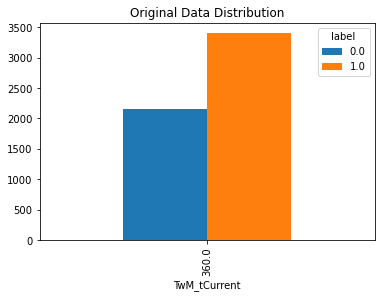

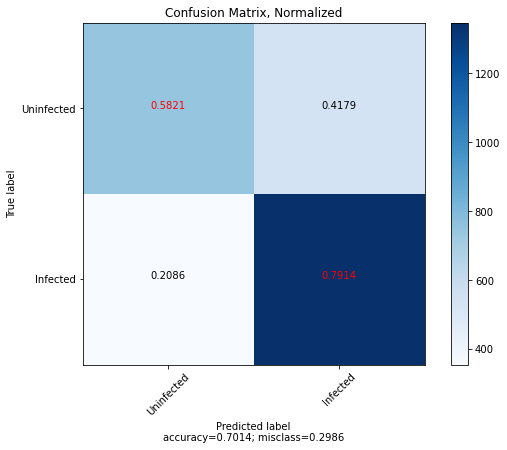

===Processing fold 1===
1.0    1285
0.0    1285
Name: label, dtype: int64
[0]	train-auc:0.735361	eval-auc:0.684516
[1]	train-auc:0.743192	eval-auc:0.69097
[2]	train-auc:0.760237	eval-auc:0.700705
[3]	train-auc:0.767029	eval-auc:0.709259
[4]	train-auc:0.777054	eval-auc:0.710967
[5]	train-auc:0.777103	eval-auc:0.712174
[6]	train-auc:0.781199	eval-auc:0.711882
[7]	train-auc:0.784358	eval-auc:0.72029
[8]	train-auc:0.786627	eval-auc:0.719245
[9]	train-auc:0.788783	eval-auc:0.718336
[10]	train-auc:0.79007	eval-auc:0.72136
[11]	train-auc:0.790942	eval-auc:0.722064
[12]	train-auc:0.79149	eval-auc:0.721989
[13]	train-auc:0.791985	eval-auc:0.721568
[14]	train-auc:0.794122	eval-auc:0.722557
[15]	train-auc:0.796846	eval-auc:0.723519
[16]	train-auc:0.79934	eval-auc:0.723481
[17]	train-auc:0.799454	eval-auc:0.723405
[18]	train-auc:0.801113	eval-auc:0.725355
[19]	train-auc:0.801816	eval-auc:0.724611
[20]	train-auc:0.803028	eval-auc:0.725616
[21]	train-auc:0.802996	eval-auc:0.725448
[22]	train-auc:0.8

[192]	train-auc:0.838814	eval-auc:0.731133
[193]	train-auc:0.839243	eval-auc:0.730984
[194]	train-auc:0.839243	eval-auc:0.730984
[195]	train-auc:0.839243	eval-auc:0.730984
[196]	train-auc:0.839243	eval-auc:0.730984
[197]	train-auc:0.839243	eval-auc:0.730984
[198]	train-auc:0.839243	eval-auc:0.730984
[199]	train-auc:0.839243	eval-auc:0.730984
[200]	train-auc:0.839243	eval-auc:0.730984
[201]	train-auc:0.839939	eval-auc:0.731211
[202]	train-auc:0.839939	eval-auc:0.731211
[203]	train-auc:0.839939	eval-auc:0.731211
[204]	train-auc:0.839939	eval-auc:0.731211
[205]	train-auc:0.84051	eval-auc:0.730935
[206]	train-auc:0.84051	eval-auc:0.730935
[207]	train-auc:0.84051	eval-auc:0.730935
[208]	train-auc:0.841388	eval-auc:0.730329
[209]	train-auc:0.841388	eval-auc:0.730329
[210]	train-auc:0.841388	eval-auc:0.730329
[211]	train-auc:0.841388	eval-auc:0.730329
[212]	train-auc:0.841388	eval-auc:0.730329
[213]	train-auc:0.841388	eval-auc:0.730329
[214]	train-auc:0.841388	eval-auc:0.730329
[215]	train-au

[384]	train-auc:0.849571	eval-auc:0.729281
[385]	train-auc:0.849571	eval-auc:0.729281
[386]	train-auc:0.849571	eval-auc:0.729281
[387]	train-auc:0.849571	eval-auc:0.729281
[388]	train-auc:0.849571	eval-auc:0.729281
[389]	train-auc:0.849571	eval-auc:0.729281
[390]	train-auc:0.849571	eval-auc:0.729281
[391]	train-auc:0.850324	eval-auc:0.728804
[392]	train-auc:0.851138	eval-auc:0.728714
[393]	train-auc:0.851138	eval-auc:0.728714
[394]	train-auc:0.851138	eval-auc:0.728714
[395]	train-auc:0.851138	eval-auc:0.728714
[396]	train-auc:0.851138	eval-auc:0.728714
[397]	train-auc:0.851138	eval-auc:0.728714
[398]	train-auc:0.851138	eval-auc:0.728714
[399]	train-auc:0.851138	eval-auc:0.728714
[400]	train-auc:0.851138	eval-auc:0.728714
[401]	train-auc:0.851138	eval-auc:0.728714
[402]	train-auc:0.851138	eval-auc:0.728714
[403]	train-auc:0.851138	eval-auc:0.728714
[404]	train-auc:0.851138	eval-auc:0.728714
[405]	train-auc:0.851138	eval-auc:0.728714
[406]	train-auc:0.851138	eval-auc:0.728714
[407]	train

[575]	train-auc:0.857586	eval-auc:0.727463
[576]	train-auc:0.857586	eval-auc:0.727464
[577]	train-auc:0.857586	eval-auc:0.727464
[578]	train-auc:0.857586	eval-auc:0.727464
[579]	train-auc:0.857586	eval-auc:0.727464
[580]	train-auc:0.857586	eval-auc:0.727464
[581]	train-auc:0.857586	eval-auc:0.727463
[582]	train-auc:0.857586	eval-auc:0.727464
[583]	train-auc:0.857586	eval-auc:0.727463
[584]	train-auc:0.858367	eval-auc:0.727189
[585]	train-auc:0.858367	eval-auc:0.727189
[586]	train-auc:0.858367	eval-auc:0.727189
[587]	train-auc:0.858367	eval-auc:0.727189
[588]	train-auc:0.858367	eval-auc:0.727189
[589]	train-auc:0.858367	eval-auc:0.727189
[590]	train-auc:0.858367	eval-auc:0.727189
[591]	train-auc:0.858367	eval-auc:0.727189
[592]	train-auc:0.858367	eval-auc:0.727189
[593]	train-auc:0.858367	eval-auc:0.727189
[594]	train-auc:0.858367	eval-auc:0.727189
[595]	train-auc:0.858367	eval-auc:0.727189
[596]	train-auc:0.858367	eval-auc:0.727189
[597]	train-auc:0.858367	eval-auc:0.727189
[598]	train

[766]	train-auc:0.862645	eval-auc:0.728068
[767]	train-auc:0.862645	eval-auc:0.728068
[768]	train-auc:0.862645	eval-auc:0.728068
[769]	train-auc:0.862645	eval-auc:0.728068
[770]	train-auc:0.862645	eval-auc:0.728068
[771]	train-auc:0.862645	eval-auc:0.728068
[772]	train-auc:0.862645	eval-auc:0.728068
[773]	train-auc:0.862645	eval-auc:0.728068
[774]	train-auc:0.862645	eval-auc:0.728068
[775]	train-auc:0.862645	eval-auc:0.728068
[776]	train-auc:0.862645	eval-auc:0.728068
[777]	train-auc:0.862645	eval-auc:0.728068
[778]	train-auc:0.862645	eval-auc:0.728068
[779]	train-auc:0.862645	eval-auc:0.728068
[780]	train-auc:0.862645	eval-auc:0.728068
[781]	train-auc:0.862645	eval-auc:0.728068
[782]	train-auc:0.862645	eval-auc:0.728068
[783]	train-auc:0.862645	eval-auc:0.728068
[784]	train-auc:0.862645	eval-auc:0.728068
[785]	train-auc:0.862645	eval-auc:0.728068
[786]	train-auc:0.862645	eval-auc:0.728068
[787]	train-auc:0.862645	eval-auc:0.728068
[788]	train-auc:0.862645	eval-auc:0.728068
[789]	train

[957]	train-auc:0.865446	eval-auc:0.727991
[958]	train-auc:0.865446	eval-auc:0.727991
[959]	train-auc:0.865446	eval-auc:0.727991
[960]	train-auc:0.865446	eval-auc:0.727991
[961]	train-auc:0.865446	eval-auc:0.727991
[962]	train-auc:0.865446	eval-auc:0.727991
[963]	train-auc:0.865446	eval-auc:0.727991
[964]	train-auc:0.865857	eval-auc:0.727886
[965]	train-auc:0.865857	eval-auc:0.727886
[966]	train-auc:0.865857	eval-auc:0.727886
[967]	train-auc:0.865857	eval-auc:0.727886
[968]	train-auc:0.865857	eval-auc:0.727886
[969]	train-auc:0.865857	eval-auc:0.727887
[970]	train-auc:0.865857	eval-auc:0.727886
[971]	train-auc:0.866101	eval-auc:0.728245
[972]	train-auc:0.866101	eval-auc:0.728245
[973]	train-auc:0.866101	eval-auc:0.728245
[974]	train-auc:0.866101	eval-auc:0.728245
[975]	train-auc:0.866101	eval-auc:0.728245
[976]	train-auc:0.866101	eval-auc:0.728245
[977]	train-auc:0.866101	eval-auc:0.728245
[978]	train-auc:0.866101	eval-auc:0.728245
[979]	train-auc:0.866101	eval-auc:0.728245
[980]	train

C:\Users\bird\Anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\bird\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


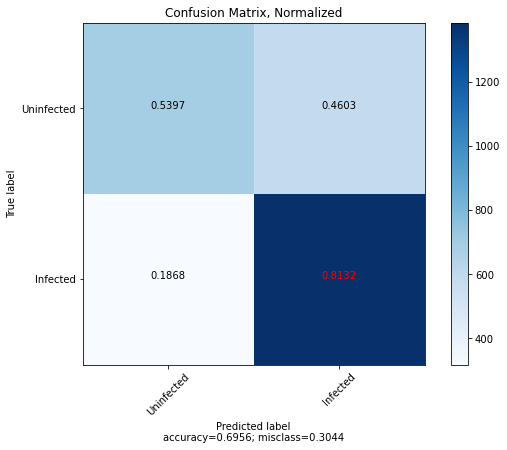

Finished cross validation
MSE: 0    0.192928
dtype: float64 
ACC: 0    0.698476
dtype: float64 
AUC: 0    0.738679
dtype: float64 
ACC for t at 210: 0   NaN
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [30]:
initial_features_path = 'F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
user_data_path = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
model_save_path = 'F:\\twitter_data\\givenchy\\pickle\\trained_model.dat'
model = xgb
data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'up')
    
